In [1]:
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import pandas_datareader as web

Get data of company using the specified API from 'start' to 'end' dates

In [2]:
start_date, end_date = "2000-01-01", "2021-12-31"
df = web.DataReader("AMZN", 'yahoo', start=start_date, end=end_date)

In [3]:
# goal is to predict closing prices
data = df.filter(['Close'])

In [4]:
# normalize data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data_array = scaler.fit_transform(data) # numpy array

In [5]:
# create DataFrame from scaled array
scaled_data = pd.DataFrame()
scaled_data['Close'] = pd.DataFrame(scaled_data_array)

In [6]:
# use 75% of data to train the model
train_data_size = int(len(data) * 0.75)
print(train_data_size)

4152


In [7]:
# partition data into train and test data
train_data = scaled_data[0:train_data_size]
test_data = scaled_data[train_data_size:]

In [8]:
train_data_array = np.array(train_data)
train_data_array.shape

(4152, 1)

Split training data into inputs and targets

In [9]:
trail = 90 # number of memory used to make prediction
x_train, y_train = [], []
for i in range(trail, train_data_array.shape[0]):
    x_train.append(train_data_array[i-trail:i])  # input will be closing prices from last 'trail' amount of days
    y_train.append(train_data_array[i,0])       # target will be closing price one day after

In [10]:
# convert to numpy arrays
x_train, y_train = np.array(x_train), np.array(y_train)

In [11]:
x_train.shape, y_train.shape

((4062, 90, 1), (4062,))

Note that x_train and y_train have the closing prices up to 'memory' days before test_data begins

In [12]:
train_data.shape[0], train_data.shape[0] - trail

(4152, 4062)

In [13]:
# build model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=100, return_sequences=False))
model.add(Dropout(0.4))
# model.add(LSTM(units=70, return_sequences=True))
# model.add(Dropout(0.4))
# model.add(LSTM(units=100, return_sequences=False))
model.add(Dropout(0.5))
model.add(Dense(units=1))

Metal device set to: Apple M1


2021-12-31 19:19:32.804185: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2021-12-31 19:19:32.804285: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [14]:
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(x_train, y_train, epochs=5)

2021-12-31 19:19:33.003709: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


Epoch 1/5


2021-12-31 19:19:33.657126: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-12-31 19:19:33.857462: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-12-31 19:19:33.991235: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-12-31 19:19:34.149153: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-12-31 19:19:34.402467: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


127/127 [==============================] - 8s 50ms/step - loss: 3.2832e-04
Epoch 2/5
127/127 [==============================] - 6s 47ms/step - loss: 1.3953e-04
Epoch 3/5
127/127 [==============================] - 6s 49ms/step - loss: 1.7780e-04
Epoch 4/5
127/127 [==============================] - 6s 48ms/step - loss: 1.6403e-04
Epoch 5/5
127/127 [==============================] - 6s 47ms/step - loss: 1.4916e-04


# Organize test data

Due to the 90 day gap, test_data must include the following

In [15]:
# test_data.head()

In [16]:
# train_data.tail(memory)

Adjust test_data accordingly

In [17]:
test_data_adj = train_data.tail(trail).append(test_data)

In [18]:
# prepare array of test_data to make inputs and targets
test_data_array = np.array(test_data_adj)

In [19]:
x_test, y_test = [], []
for i in range(trail, test_data_array.shape[0]):
    x_test.append(test_data_array[i-trail:i])
    y_test.append(test_data_array[i])

In [20]:
# verify
len(x_test), len(y_test), test_data.shape, test_data.shape[0]

(1384, 1384, (1384, 1), 1384)

In [21]:
# prepare inputs and targets to be read
x_test, y_test = np.array(x_test), np.array(y_test)

In [22]:
# verify dims
x_test.shape, y_test.shape

((1384, 90, 1), (1384, 1))

In [23]:
scaled_predictions = model.predict(x_test) 

2021-12-31 19:20:05.447788: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-12-31 19:20:05.510181: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-12-31 19:20:05.624537: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


In [24]:
# recall that the test data is normalized
# scaled_predictions

In [25]:
predictions = scaler.inverse_transform(scaled_predictions)
# predictions

In [26]:
# compute error
rmse = np.sqrt(np.mean(scaled_predictions - y_test)**2) # root mean squared error
rmse

0.04906118815870151

# Prepare data to be plotted

In [27]:
train = data[:train_data_size]
test = data[train_data_size:] # should have same length as predictions 
len(test)

1384

In [28]:
# test

In [29]:
test.insert(loc=1, column='Predictions', value=predictions)
# test

In [30]:
pd.DataFrame(predictions)

,0
0,773.713074
1,776.764221
2,780.290527
3,784.356018
4,789.091187
...,...
1379,3777.385010
1380,3775.303467
1381,3774.283203
1382,3772.319824


In [31]:
# valid['Predictions'] = y_predictions
# test

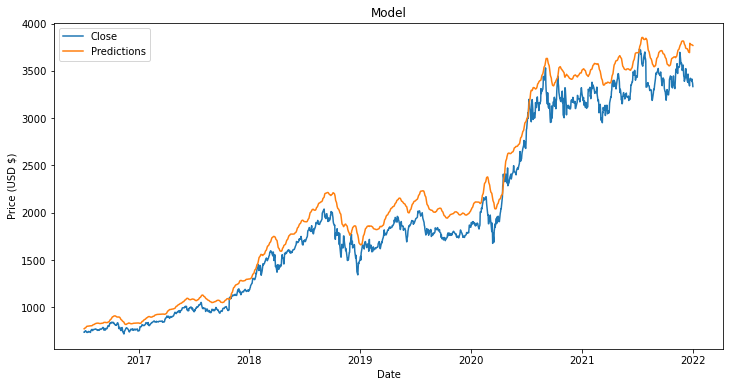

In [32]:
plt.figure(figsize=(12, 6))
plt.title('Model')
plt.xlabel('Date')
plt.ylabel('Price (USD $)')
plt.plot(test[['Close', 'Predictions']])
plt.legend(['Close', 'Predictions'], loc="upper left")
plt.show()

In [33]:
# model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])
# model.fit(x_train, y_train, validation_data = (x_test, y_test), epochs=5, batch_size=1)